In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import keras.backend as K
from keras.metrics import SparseCategoricalAccuracy
from keras.losses import SparseCategoricalCrossentropy

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

import gpustat
gpustat.print_gpustat()
os.environ['CUDA_VISIBLE_DEVICES']='3'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 0
gpu-ibanks-3.hep.caltech.edu  Thu Aug 26 19:29:38 2021  470.57.02
[0] NVIDIA GeForce GTX 1080 | 22'C,   0 % |     1 /  8119 MB |
[1] NVIDIA GeForce GTX 1080 | 24'C,   0 % |     1 /  8119 MB |
[2] NVIDIA GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |
[3] NVIDIA GeForce GTX 1080 | 22'C,   0 % |     1 /  8119 MB |
[4] NVIDIA GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |
[5] NVIDIA GeForce GTX 1080 | 25'C,   0 % |   727 /  8119 MB | 3012(723M)
[6] NVIDIA GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |
[7] NVIDIA GeForce GTX 1080 | 27'C,   0 % |     1 /  8119 MB |


### Load MC samples

In [2]:
def samp_to_df(samp_name, total_num):
    dfs = []
    tree_vars = [b'leading_photon_pt', b'subleading_photon_pt', b'diphoton_pt', b'diphoton_mass',
           b'leading_bjet_pt', b'subleading_bjet_pt', b'dibjet_pt', b'dibjet_mass',
           b'leading_bjet_pt_corr', b'subleading_bjet_pt_corr', b'dibjet_pt_corr', b'dibjet_mass_corr',
           b'leading_pho_pt_over_dimass', b'leading_bjet_pt_over_dimass', b'leading_bjet_pt_over_dimass_corr',
           b'subleading_pho_pt_over_dimass', b'subleading_bjet_pt_over_dimass', b'subleading_bjet_pt_over_dimass_corr',
           b'leading_photon_phi', b'leading_photon_eta', b'subleading_photon_phi', b'subleading_photon_eta',
           b'diphoton_eta', b'photon_delR', b'diphoton_pt_over_diphoton_mass',
           b'leading_bjet_phi', b'leading_bjet_eta', b'subleading_bjet_phi', b'subleading_bjet_eta',
           b'dibjet_eta', b'bjet_delR', b'dibjet_pt_over_dibjet_mass', b'dibjet_pt_over_dibjet_mass_corr',
           b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
           b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
           b'leading_vbfjet_pt', b'subleading_vbfjet_pt', b'divbfjet_pt', b'divbfjet_mass',
           b'leading_vbfjet_phi', b'leading_vbfjet_eta', b'subleading_vbfjet_phi', b'subleading_vbfjet_eta',
           b'leading_vbfjet_pt_over_dimass', b'subleading_vbfjet_pt_over_dimass', b'divbfjet_pt_over_dimass',
           b'divbfjet_eta', b'vbfjet_delR', b'vbfjet_del_eta',
           b'MET_pt', b'MET_phi', b'MET_sumEt',
           b'recon', b'ggHH_recon', b'VBFHH_recon', b'genweight', b'nbjet', b'nvbfjet', b'nphoton', b'njet',
           b'run', b'lumi', b'event']
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays(tree_vars)
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs)
    return combine_df

In [4]:
# Set up dataframes - 2018 

# Signals
GluGluToHH_df_2018 = samp_to_df('job_2_ntuple20180819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2018= samp_to_df('job_3_ntuple20180819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8Job3ifile', 0)

# Backgrounds
VHToGG_df_2018 = samp_to_df('job_4_ntuple20180819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2018 = samp_to_df('job_5_ntuple20180819v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8Job5ifile', 0)
VBFHToGG_df_2018 = samp_to_df('job_6_ntuple20180819v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8Job6ifile', 0)
GluGluHToGG_df_2018 = samp_to_df('job_7_ntuple20180819v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8Job7ifile', 0)
TTJets_df_2018 = samp_to_df('job_8_ntuple20180819v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job8ifile', 60)
TTGJets_df_2018 = samp_to_df('job_9_ntuple20180819v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 3)
TTGG_0Jets_df_2018 = samp_to_df('job_10_ntuple20180819v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job10ifile', 5)
GJet_SmallPt_df_2018 = samp_to_df('job_11_ntuple20180819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 3)
GJet_BigPt_df_2018 = samp_to_df('job_12_ntuple20180819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job12ifile', 2)
DiPhotonJetsBox_df_2018 = samp_to_df('job_13_ntuple20180819v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob13ifile', 4)
DiPhotonJetsBox1B_df_2018 = samp_to_df('job_14_ntuple20180819v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob14ifile', 0)
DiPhotonJetsBox2B_df_2018 = samp_to_df('job_15_ntuple20180819v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob15ifile', 0)
QCD_Jets_df_2018 = samp_to_df('job_16_ntuple20180819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job16ifile', 15)

# Set up dataframes - 2017

# Signals
GluGluToHH_df_2017 = samp_to_df('job_2_ntuple20170819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 3)
VBFHH_df_2017 = samp_to_df('job_3_ntuple20170819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 1)

# Backgrounds
VHToGG_df_2017 = samp_to_df('job_4_ntuple20170819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2017 = samp_to_df('job_5_ntuple20170819v1/ttHToGG_M125_13TeV_powheg_pythia8Job5ifile', 0)
VBFHToGG_df_2017 = samp_to_df('job_6_ntuple20170819v1/VBFHToGG_M-125_13TeV_powheg_pythia8Job6ifile', 2)
GluGluHToGG_df_2017 = samp_to_df('job_7_ntuple20170819v1/GluGluHToGG_M-125_13TeV_powheg_pythia8Job7ifile', 0)
TTJets_df_2017 = samp_to_df('job_8_ntuple20170819v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job8ifile', 38)
TTGJets_df_2017 = samp_to_df('job_9_ntuple20170819v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 10)
TTGG_0Jets_df_2017 = samp_to_df('job_10_ntuple20170819v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job10ifile', 1)
GJet_SmallPt_df_2017 = samp_to_df('job_11_ntuple20170819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 2)
GJet_BigPt_df_2017 = samp_to_df('job_12_ntuple20170819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job12ifile', 20)
DiPhotonJetsBox_df_2017 = samp_to_df('job_1_ntuple20170819v2/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob1ifile', 16)
DiPhotonJetsBox1B_df_2017 = samp_to_df('job_14_ntuple20170819v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob14ifile', 3)
DiPhotonJetsBox2B_df_2017 = samp_to_df('job_15_ntuple20170819v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob15ifile', 5)
QCD_Jets_df_2017 = samp_to_df('job_16_ntuple20170819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job16ifile', 3)

# Set up dataframes - 2016 

# Signals
GluGluToHH_df_2016 = samp_to_df('job_2_ntuple20160819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2016 = samp_to_df('job_3_ntuple20160819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 0)

# Background
VHToGG_df_2016 = samp_to_df('job_4_ntuple20160819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2016 = samp_to_df('job_5_ntuple20160819v1/ttHToGG_M125_13TeV_powheg_pythia8_v2Job5ifile', 0)
VBFHToGG_df_2016 = samp_to_df('job_6_ntuple20160819v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8_v2Job6ifile', 2)
GluGluHToGG_df_2016 = samp_to_df('job_7_ntuple20160819v1/GluGluHToGG_M125_13TeV_amcatnloFXFX_pythiaJob7ifile', 0)
TTJets_df_2016 = samp_to_df('job_8_ntuple20160819v1/TTJets_TuneCUETP8M2T4_13TeV-amcatnloFXFX-pythia8Job8ifile', 8)
TTGJets_df_2016 = samp_to_df('job_9_ntuple20160819v1/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 2)
TTGG_0Jets_df_2016 = samp_to_df('job_10_ntuple20160819v1/TTGG_0Jets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8Job10ifile', 0)
GJet_SmallPt_df_2016 = samp_to_df('job_11_ntuple20160819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job11ifile', 2)
GJet_BigPt_df_2016 = samp_to_df('job_12_ntuple20160819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job12ifile', 12)
DiPhotonJetsBox_df_2016 = samp_to_df('job_13_ntuple20160819v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob13ifile', 9)
DiPhotonJetsBox1B_df_2016 = samp_to_df('job_14_ntuple20160819v1/DiPhotonJetsBox1BJet_MGG-80toInf_TuneSherpa_13TeV-SherpaJob14ifile', 3)
DiPhotonJetsBox2B_df_2016 = samp_to_df('job_15_ntuple20160819v1/DiPhotonJetsBox2BJets_MGG-80toInf_TuneSherpa_13TeV-SherpaJob15ifile', 4)
QCD_Jets_df_2016 = samp_to_df('job_16_ntuple20160819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job16ifile', 3)

# Combine by sample (recon == 1; photon cut == 90)

# Signals 
GluGluToHH_df = pd.concat([GluGluToHH_df_2018, GluGluToHH_df_2017, GluGluToHH_df_2016], ignore_index=True)
VBFHH_df = pd.concat([VBFHH_df_2018, VBFHH_df_2017, VBFHH_df_2016], ignore_index=True)

# Backgrounds
VHToGG_df = pd.concat([VHToGG_df_2018, VHToGG_df_2017, VHToGG_df_2016], ignore_index=True)
ttHToGG_df = pd.concat([ttHToGG_df_2018, ttHToGG_df_2017, ttHToGG_df_2016], ignore_index=True)
VBFHToGG_df = pd.concat([VBFHToGG_df_2018, VBFHToGG_df_2017, VBFHToGG_df_2016], ignore_index=True)
GluGluHToGG_df = pd.concat([GluGluHToGG_df_2018, GluGluHToGG_df_2017, GluGluHToGG_df_2016], ignore_index=True)
TTJets_df= pd.concat([TTJets_df_2018, TTJets_df_2017, TTJets_df_2016], ignore_index=True)
TTGJets_df = pd.concat([TTGJets_df_2018, TTGJets_df_2017, TTGJets_df_2016], ignore_index=True)
TTGG_0Jets_df = pd.concat([TTGG_0Jets_df_2018, TTGG_0Jets_df_2017, TTGG_0Jets_df_2016], ignore_index=True)
GJet_SmallPt_df = pd.concat([GJet_SmallPt_df_2018, GJet_SmallPt_df_2017, GJet_SmallPt_df_2016], ignore_index=True)
GJet_BigPt_df = pd.concat([GJet_BigPt_df_2018, GJet_BigPt_df_2017, GJet_BigPt_df_2016], ignore_index=True)
DiPhotonJetsBox_df = pd.concat([DiPhotonJetsBox_df_2018, DiPhotonJetsBox_df_2017, DiPhotonJetsBox_df_2016], ignore_index=True)
DiPhotonJetsBox1B_df = pd.concat([DiPhotonJetsBox1B_df_2018, DiPhotonJetsBox1B_df_2017, DiPhotonJetsBox1B_df_2016], ignore_index=True)
DiPhotonJetsBox2B_df = pd.concat([DiPhotonJetsBox2B_df_2018, DiPhotonJetsBox2B_df_2017, DiPhotonJetsBox2B_df_2016], ignore_index=True)
QCD_Jets_df = pd.concat([QCD_Jets_df_2018, QCD_Jets_df_2017, QCD_Jets_df_2016], ignore_index=True)

In [5]:
# Select ggHH signal specifically -- pho == 90

dfs_combine = [GluGluToHH_df, VBFHH_df,
               VHToGG_df, ttHToGG_df, VBFHToGG_df, GluGluHToGG_df, 
                TTJets_df, TTGJets_df, TTGG_0Jets_df, 
            GJet_SmallPt_df, GJet_BigPt_df,
             DiPhotonJetsBox_df, DiPhotonJetsBox1B_df, DiPhotonJetsBox2B_df, QCD_Jets_df]

dfs_ggHH = []

for i in range(len(dfs_combine)):
    if i == 11: # downsize DiPhotonJetsBox
        df_ggHH = dfs_combine[i][dfs_combine[i][b'ggHH_recon'] == 1]
        df_ggHH_shuff = df_ggHH.sample(frac=1).reset_index(drop=True)
        df_ggHH_short = df_ggHH_shuff.truncate(after = 197069)
        df_total_weight = np.sum(df_ggHH.loc[:, b'genweight'].values)
        df_short_weight = np.sum(df_ggHH_short.loc[:, b'genweight'].values)
        df_ggHH_short[b'genweight'] = df_ggHH_short.loc[:, b'genweight'].values * df_total_weight / df_short_weight
        dfs_ggHH.append(df_ggHH_short)
    else:
        df_ggHH = dfs_combine[i][dfs_combine[i][b'ggHH_recon'] == 1]
        dfs_ggHH.append(df_ggHH)

## Preprocessing

In [6]:
mc_labels = ['GluGluToHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

dfs_ggHH_label = []
total = 0
for i in range(len(mc_labels)):
    df = pd.DataFrame()
    for column in list(dfs_ggHH[i].columns):
        df[column] = dfs_ggHH[i].loc[:, column].values
    samp_label = [mc_labels[i]] * len(dfs_ggHH[i].index)
    df[b'label'] = samp_label
    print(mc_labels[i])
    print(len(dfs_ggHH[i].index))
    total += len(dfs_ggHH[i].index)
    samp_label_num = [i] * len(dfs_ggHH[i].index)
    df[b'label_num'] = samp_label_num
    dfs_ggHH_label.append(df)

full_df = pd.concat(dfs_ggHH_label, ignore_index=True)
print(total)
print(len(full_df.index))
print(full_df[b'label'].value_counts())
full_df.head()

GluGluToHH
115095
VBFToHH
123786
VHToGG
150739
ttHToGG
128314
VBFHToGG
117796
GluGluHtoGG
131781
TTJets
233707
TTGJets
80870
TTGG_0Jets
45301
GJet_SmallPt
2565
GJet_BigPt
78388
DiPhotonJetsBox
197070
DiPhotonJetsBox1B
79813
DiPhotonJetsBox2B
43283
QCDJets
414
1528922
1528922
TTJets               233707
DiPhotonJetsBox      197070
VHToGG               150739
GluGluHtoGG          131781
ttHToGG              128314
VBFToHH              123786
VBFHToGG             117796
GluGluToHH           115095
TTGJets               80870
DiPhotonJetsBox1B     79813
GJet_BigPt            78388
TTGG_0Jets            45301
DiPhotonJetsBox2B     43283
GJet_SmallPt           2565
QCDJets                 414
Name: b'label', dtype: int64


,b'leading_photon_pt',b'subleading_photon_pt',b'diphoton_pt',b'diphoton_mass',b'leading_bjet_pt',b'subleading_bjet_pt',b'dibjet_pt',b'dibjet_mass',b'leading_bjet_pt_corr',b'subleading_bjet_pt_corr',...,b'genweight',b'nbjet',b'nvbfjet',b'nphoton',b'njet',b'run',b'lumi',b'event',b'label',b'label_num'
0,81.548317,68.587204,84.036278,124.439453,80.1250,60.7500,88.046196,111.977684,89.827637,63.123047,...,-0.000028,3,0,2,6,1,1121,112017,GluGluToHH,0
1,109.037231,87.997322,153.144653,124.160385,115.9375,69.3125,160.948395,111.282120,117.749023,75.133667,...,0.000028,2,0,2,5,1,1121,112010,GluGluToHH,0
2,99.698898,54.716755,92.352104,124.160637,92.5625,26.7500,112.699577,106.316811,100.517090,32.967285,...,0.000028,2,1,2,10,1,1121,112001,GluGluToHH,0
3,78.673645,74.914726,111.698479,120.000145,178.5000,31.0625,172.392776,125.170486,164.816162,27.756042,...,0.000028,2,0,2,13,1,1121,112006,GluGluToHH,0
4,447.419708,159.403656,594.103027,123.621674,485.0000,46.3750,525.561584,98.438232,465.817871,57.153564,...,0.000028,2,0,2,8,1,1121,112019,GluGluToHH,0


In [7]:
# define variables
training_vars = [b'leading_photon_eta', b'leading_photon_phi', 
                b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt_corr', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt_corr', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'subleading_pho_pt_over_dimass',
                 b'diphoton_pt_over_diphoton_mass', b'dibjet_pt_over_dibjet_mass_corr',
                 b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
                 b'MET_pt', b'MET_phi', b'MET_sumEt',
                 b'nbjet', b'nphoton', b'njet'
                ]

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

# select df columns
x_dfs = []


x_df = full_df[training_vars]
x_full_df = full_df[training_vars + aug_vars + w_var]
y_df = full_df[b'label_num']
X = x_df.values
X_weights = full_df[w_var].values
Y = y_df.values

In [8]:
# split into training and test; following: https://www.kaggle.com/hungdo1291/keras-dnn-multi-class
random_seed=2
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=random_seed)
X_train_weight, X_val_weight, ph_1, ph_2 = train_test_split(X_weights, Y, test_size = 0.2, random_state=random_seed)

## Model Setup

In [9]:
def multi_DNN(n_hidden = 2, first_neuron = 100, n_neurons = 64, dropout_rate = 0.3, activation_func = 'sigmoid', lr= 0.00002):
    model = Sequential()
    model.add(Dense(first_neuron, input_dim=len(training_vars), activation='relu'))
    model.add(Dropout(dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = activation_func))
        model.add(Dropout(dropout_rate))
    model.add(Dense(15, activation = 'softmax'))
    opt = Adam(learning_rate = lr)
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=opt, metrics=[SparseCategoricalAccuracy()])
    return model

## Model Test

In [25]:
model = multi_DNN()
history = model.fit(X_train, Y_train, epochs=1000,batch_size=64, validation_split = 0.2, 
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')])

Epoch 1/1000
15290/15290 [==============================] - 27s 2ms/step - loss: 2.5478 - sparse_categorical_accuracy: 0.1324 - val_loss: 2.4583 - val_sparse_categorical_accuracy: 0.1660
Epoch 2/1000
15290/15290 [==============================] - 27s 2ms/step - loss: 2.4779 - sparse_categorical_accuracy: 0.1575 - val_loss: 2.4380 - val_sparse_categorical_accuracy: 0.1934
Epoch 3/1000
15290/15290 [==============================] - 27s 2ms/step - loss: 2.4500 - sparse_categorical_accuracy: 0.1761 - val_loss: 2.4079 - val_sparse_categorical_accuracy: 0.1971
Epoch 4/1000
15290/15290 [==============================] - 26s 2ms/step - loss: 2.4167 - sparse_categorical_accuracy: 0.1917 - val_loss: 2.3331 - val_sparse_categorical_accuracy: 0.2194
Epoch 5/1000
15290/15290 [==============================] - 27s 2ms/step - loss: 2.3647 - sparse_categorical_accuracy: 0.2060 - val_loss: 2.2760 - val_sparse_categorical_accuracy: 0.2282
Epoch 6/1000
15290/15290 [==============================] - 27s 2

In [26]:
evalu_val = model.evaluate(X_val, Y_val)
metrics = model.metrics_names
print(f"{metrics[1]}: {evalu_val[1]}")
print(f"{metrics[0]}: {evalu_val[0]}")

9556/9556 [==============================] - 11s 1ms/step - loss: 1.7256 - sparse_categorical_accuracy: 0.3956
sparse_categorical_accuracy: 0.39563417434692383
loss: 1.7255982160568237


In [27]:
evalu_train = model.evaluate(X_train, Y_train)
metrics = model.metrics_names
print(f"{metrics[1]}: {evalu_train[1]}")
print(f"{metrics[0]}: {evalu_train[0]}")

38224/38224 [==============================] - 42s 1ms/step - loss: 1.7245 - sparse_categorical_accuracy: 0.3943
sparse_categorical_accuracy: 0.39431723952293396
loss: 1.7244577407836914


In [44]:
compare = pd.DataFrame()
output = model.predict(X_val)
#compare['output'] = output
predict_lab = []
predict_name = []
actual_name = []
sig_prob = []
prob_ratio = []
for i in range(output.shape[0]):
    label = np.argmax(output[i])
    predict_lab.append(label)
    predict_name.append(mc_labels[label])
    actual_name.append(mc_labels[Y_val[i]])
    sum_prob = 0
    for j in range(14):
        sum_prob += output[i][j+1]
    prob_ratio.append(output[i][0] / sum_prob)
    sig_prob.append(output[i][0])
compare['predicted_label'] = predict_lab
compare['actual_label'] = Y_val
compare['predicted_name'] = predict_name
compare['actual_name'] = actual_name
compare['sig_prob'] = sig_prob
compare['prob_ratio'] = prob_ratio

In [45]:
print(predict_lab.count(0) / len(predict_lab))
print(np.count_nonzero(Y_val == 0) / Y_val.shape[0])
print(np.count_nonzero(Y_train == 0) / Y_train.shape[0])
print(np.count_nonzero(Y_val == 0) + np.count_nonzero(Y_train == 0))

0.08450054777049235
0.0747257059698808
0.0754167358194544
115095


In [46]:
compare.sample(n=50)

,predicted_label,actual_label,predicted_name,actual_name,sig_prob,prob_ratio
219579,6,3,TTJets,ttHToGG,0.048527,0.051002
13587,0,0,GluGluToHH,GluGluToHH,0.529122,1.123693
267586,12,12,DiPhotonJetsBox1B,DiPhotonJetsBox1B,0.043671,0.045665
64960,5,11,GluGluHtoGG,DiPhotonJetsBox,0.002051,0.002055
91564,12,1,DiPhotonJetsBox1B,VBFToHH,0.034320,0.035540
170500,1,1,VBFToHH,VBFToHH,0.357128,0.555519
10885,5,4,GluGluHtoGG,VBFHToGG,0.003505,0.003517
83886,6,7,TTJets,TTGJets,0.001580,0.001582
91785,0,13,GluGluToHH,DiPhotonJetsBox2B,0.286061,0.400680
169287,11,3,DiPhotonJetsBox,ttHToGG,0.003008,0.003017


In [47]:
y_pred = []
y_act = []
for i in range(Y_val.shape[0]):
    if Y_val[i] == 0:
        y_act.append(1)
    else:
        y_act.append(0)
    if predict_lab[i] == 0:
        y_pred.append(1)
    else:
        y_pred.append(0)

## Plotting Results

In [48]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_act, y_pred, sample_weight = X_val_weight)
auc_keras = auc(fpr_keras, tpr_keras)

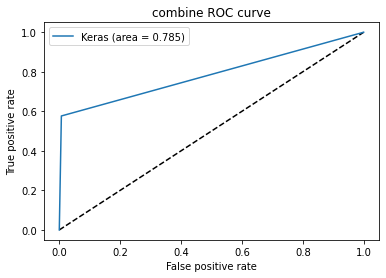

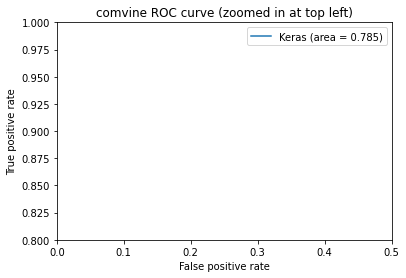

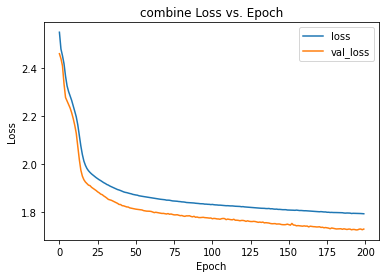

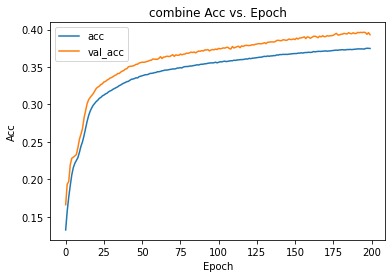

In [49]:
# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('combine ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/multi_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('comvine ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/multi_ROC_curve_zoom')
plt.show()

# plot loss vs epoch
plt.figure(3)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('combine Loss vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/multi_loss_epoch.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(history.history['sparse_categorical_accuracy'], label='acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('combine Acc vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/multi_acc_epoch.png', format='png')
plt.show()

In [50]:
total_weight = np.sum(full_df.loc[:, b'genweight'].values)
test_total_weight = np.sum(X_val_weight)
scale_weight = total_weight / test_total_weight

In [51]:
# Make copy of dataframe
X_full = full_df.values
X_train_full, X_val_full, y_ph_1, y_ph_2 = train_test_split(X_full, Y, test_size = 0.2, random_state=random_seed)
X_val_full_df = pd.DataFrame(X_val_full, columns = list(full_df.columns))

result_df = pd.DataFrame()
for column in list(full_df.columns):
    result_df[column] = X_val_full_df.loc[:, column].values
result_df[b'genweight_scale'] = X_val_full_df.loc[:, b'genweight'] * scale_weight
result_df[b'actual_label'] = Y_val
result_df[b'predicted_label'] = predict_lab
result_df[b'sig_prob'] = sig_prob
result_df[b'prob_ratio'] = prob_ratio

In [52]:
result_df.head()

,b'leading_photon_pt',b'subleading_photon_pt',b'diphoton_pt',b'diphoton_mass',b'leading_bjet_pt',b'subleading_bjet_pt',b'dibjet_pt',b'dibjet_mass',b'leading_bjet_pt_corr',b'subleading_bjet_pt_corr',...,b'run',b'lumi',b'event',b'label',b'label_num',b'genweight_scale',b'actual_label',b'predicted_label',b'sig_prob',b'prob_ratio'
0,100.653,77.6155,171.578,117.614,98,60.7812,38.5725,156.278,98.957,67.6666,...,1,107,106462,DiPhotonJetsBox1B,12,0.095769,12,3,0.165959,0.198982
1,130.761,39.5083,150.451,130.177,69.5,39.625,75.1843,100.475,73.708,56.1096,...,1,498,1491548,TTGG_0Jets,8,0.00294742,8,3,0.024795,0.025426
2,84.8645,46.9327,68.5444,126.857,91.875,34.5312,87.247,93.4732,94.4769,29.7765,...,1,14435,4546719,GluGluHtoGG,5,0.0302446,5,4,0.010506,0.010617
3,95.5568,53.9212,142.03,106.634,121.5,34.8125,148.869,93.0338,123.517,35.0505,...,1,226618,12237339,TTGJets,7,0.149898,7,3,0.039569,0.041199
4,48.7047,35.4135,15.585,137.343,54.2188,52.2812,41.845,123.469,56.1778,59.0206,...,1,6935,9909739,TTJets,6,-2.0635,6,6,0.005762,0.005796


In [53]:
mc_labels = ['GluGluToHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

for i in range(len(mc_labels)-1):
    sig_df = result_df[result_df[b'actual_label'] == 0]
    samp_df = result_df[result_df[b'actual_label'] == i+1]
    bgd_weight = samp_df.loc[:, b'genweight_scale'].values
    sgl_weight = sig_df.loc[:, b'genweight_scale'].values
    bgd_sig_prob = samp_df.loc[:, b'sig_prob'].values
    sgl_sig_prob = sig_df.loc[:, b'sig_prob'].values
    bgd_prob_rat = samp_df.loc[:, b'prob_ratio'].values
    sgl_prob_rat = sig_df.loc[:, b'prob_ratio'].values
    
    plt.figure(figsize=(9,6))
    plt.hist(bgd_sig_prob, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= f'{mc_labels[i+1]} background', density = True)
    plt.hist(sgl_sig_prob, color='orange', weights= sgl_weight, histtype='step', bins = 20, label= 'ggHH signal', density = True)
    plt.xlabel('probability of being ggHH')
    plt.ylabel('Number of Events')
    plt.legend(loc = 'best')
    plt.title(f'signal probability for {mc_labels[i+1]} background')
    plt.savefig(fname = f'Multi_Prob_Plts/sig_prob_{mc_labels[i+1]}.png', format='png')
    plt.close()
    
    plt.figure(figsize=(9,6))
    plt.hist(bgd_prob_rat, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= f'{mc_labels[i+1]} background', density = True)
    plt.hist(sgl_prob_rat, color='orange', weights= sgl_weight, histtype='step', bins = 20, label= 'ggHH signal', density = True)
    plt.xlabel('probability ratio')
    plt.ylabel('Number of Events')
    plt.legend(loc = 'best')
    plt.title(f'probability ratio for {mc_labels[i+1]} background')
    plt.savefig(fname = f'Multi_Prob_Plts/prob_ratio_{mc_labels[i+1]}.png', format='png')
    plt.close()

In [54]:
sig_df = result_df[result_df[b'actual_label'] == 0]
bgd_df = result_df[result_df[b'actual_label'] != 0]
bgd_weight = bgd_df.loc[:, b'genweight_scale'].values
sgl_weight = sig_df.loc[:, b'genweight_scale'].values
bgd_sig_prob = bgd_df.loc[:, b'sig_prob'].values
sgl_sig_prob = sig_df.loc[:, b'sig_prob'].values
bgd_prob_rat = bgd_df.loc[:, b'prob_ratio'].values
sgl_prob_rat = sig_df.loc[:, b'prob_ratio'].values

plt.figure(figsize=(9,6))
plt.hist(bgd_sig_prob, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= f'combined background', density = True)
plt.hist(sgl_sig_prob, color='orange', weights= sgl_weight, histtype='step', bins = 20, label= 'ggHH signal', density = True)
plt.xlabel('Probability of being ggHH')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title(f'Signal probability for combined background')
plt.savefig(fname = f'Multi_Prob_Plts/sig_prob_combined.png', format='png')
plt.close()

plt.figure(figsize=(9,6))
plt.hist(bgd_prob_rat, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= f'combined background', density = True)
plt.hist(sgl_prob_rat, color='orange', weights= sgl_weight, histtype='step', bins = 20, label= 'ggHH signal', density = True)
plt.xlabel('Probability ratio')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title(f'Probability ratio for combined background')
plt.savefig(fname = f'Multi_Prob_Plts/prob_ratio_combined.png', format='png')
plt.close()

In [30]:
from ROOT import RDF
from ROOT import Internal

result_dict = {key.decode("utf-8"): result_df[key].values for key in list(result_df.columns)}
result_rdf = rt.RDF.MakeNumpyDataFrame(result_dict)
result_rdf.Snapshot('tree', f'DNN_Trees/full/multi_DNN_file.root')

RuntimeError: Object not convertible: Dictionary entry leading_photon_pt is not convertible with AsRVec.

In [40]:
mc_labels = ['GluGluToHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

for i in range(len(mc_labels)):
    print(mc_labels[i])
    original_yield = np.sum(dfs_ggHH[i].loc[:, b'genweight'].values)
    samp_df = result_df[result_df[b'actual_label'] == i]
    remaining_df = samp_df[samp_df[b'predicted_label']==0]
    remaining_yield = np.sum(remaining_df.loc[:, b'genweight_scale'].values)
    print(f'Original yield: {original_yield}')
    print(f'Remaining yield: {remaining_yield}')
    print('\n')

original_bkd_yield = np.sum(full_df[full_df[b'label_num'] != 0].loc[:, b'genweight'].values)
original_sig_yield = np.sum(full_df[full_df[b'label_num'] == 0].loc[:, b'genweight'].values)
original_significance = original_sig_yield / np.sqrt(original_bkd_yield + original_sig_yield)
val_bkd = result_df[result_df[b'label_num'] != 0]
val_sig = result_df[result_df[b'label_num'] == 0]
remaining_bkd_yield = np.sum(val_bkd[val_bkd[b'predicted_label'] == 0].loc[:, b'genweight_scale'].values)
remaining_sig_yield = np.sum(val_sig[val_sig[b'predicted_label'] == 0].loc[:, b'genweight_scale'].values)
remaining_significance = remaining_sig_yield / np.sqrt(remaining_bkd_yield + remaining_sig_yield)
print(f'Original Background Yield: {original_bkd_yield}')
print(f'Original Signal Yield: {original_sig_yield}')
print(f'Original Significance: {original_significance}')
print(f'Remaining Background Yield: {remaining_bkd_yield}')
print(f'Remaining Signal Yield: {remaining_sig_yield}')
print(f'Remaining Significance: {remaining_significance}')

GluGluToHH
Original yield: 2.160290479660034
Remaining yield: 1.177638714036416


VBFToHH
Original yield: 0.04713541641831398
Remaining yield: 0.007356589489655327


VHToGG
Original yield: 77.61676788330078
Remaining yield: 3.2736566410947727


ttHToGG
Original yield: 8.006531715393066
Remaining yield: 0.611185896269145


VBFHToGG
Original yield: 33.00462341308594
Remaining yield: 0.7481544547091739


GluGluHtoGG
Original yield: 446.37933349609375
Remaining yield: 7.875159320026311


TTJets
Original yield: 57538.75
Remaining yield: 1410.3838172175408


TTGJets
Original yield: 2033.285400390625
Remaining yield: 103.80603578044578


TTGG_0Jets
Original yield: 20.19515609741211
Remaining yield: 0.7153843819598243


GJet_SmallPt
Original yield: 1537.787841796875
Remaining yield: 0


GJet_BigPt
Original yield: 60913.47265625
Remaining yield: 235.28799654139874


DiPhotonJetsBox
Original yield: 80835.21875
Remaining yield: 340.9978357167854


DiPhotonJetsBox1B
Original yield: 2525.9030761718

In [41]:
mc_labels = ['GluGluToHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

for i in range(len(mc_labels)):
    original_mass_gg = dfs_ggHH[i].loc[:, b'diphoton_mass'].values
    original_mass_jj = dfs_ggHH[i].loc[:, b'dibjet_mass_corr'].values
    original_weight = dfs_ggHH[i].loc[:, b'genweight'].values
    samp_df = result_df[result_df[b'actual_label'] == i]
    remaining_df = samp_df[samp_df[b'predicted_label']==0]
    remaining_mass_gg = remaining_df.loc[:, b'diphoton_mass'].values
    remaining_mass_jj = remaining_df.loc[:, b'dibjet_mass_corr'].values
    remaining_weight = remaining_df.loc[:, b'genweight'].values
    
    
    bins = np.linspace(110, 140, 20)
    
    # M_gg plot
    plt.figure(figsize=(9,6))
    plt.hist(original_mass_gg, bins=bins, weights=original_weight, density=True, label = f'{mc_labels[i]} Original', color = 'blue')
    plt.hist(remaining_mass_gg, bins=bins, weights=remaining_weight, density=True, label = f'{mc_labels[i]} Remaining', color='orange', histtype='step')
    plt.xlabel('diphoton mass')
    plt.ylabel('normalized number of events')
    plt.title(f'{mc_labels[i]} Diphoton Mass Sculpting')
    plt.legend(loc='best')
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/multi_gg_mass_sculpt_{mc_labels[i]}')
    plt.close()
    
    # M_jj plot
    plt.figure(figsize=(9,6))
    plt.hist(original_mass_jj, bins=bins, weights=original_weight, density=True, label = f'{mc_labels[i]} Original', color= 'blue')
    plt.hist(remaining_mass_jj, bins=bins, weights=remaining_weight, density=True, label = f'{mc_labels[i]} Remaining', color = 'orange', histtype='step')
    plt.xlabel('dibjet corrected mass')
    plt.ylabel('normalized number of events')
    plt.title(f'{mc_labels[i]} Dibjet Corrected Mass Sculpting')
    plt.legend(loc='best')
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/multi_jj_mass_sculpt_{mc_labels[i]}')
    plt.close()

/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


## Model Optimization

In [ ]:
space  = [Integer(1, 5, name='n_hidden'),
          Integer(10, 128, name='first_neuron'),
          Integer(10, 128, name = 'n_neurons'),
          Real(0.01,0.9,name='dropout_rate'),
          Categorical(['relu', 'sigmoid', 'softmax']),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate')
         ]

def multi_DNN(n_hidden = 1, first_neuron = 100, n_neurons = 64, dropout_rate = 0.4, activation_func = 'sigmoid', lr= 0.00002):
    model = Sequential()
    model.add(Dense(first_neuron, input_dim=len(training_vars), activation='relu'))
    model.add(Dropout(dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = activation_func))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    opt = Adam(learning_rate = lr)
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=opt, metrics=[SparseCategoricalAccuracy()])
    return model

# @use_named_args(space)
# def objective(**X):
#     print("New configuration: {}".format(X))
#     model_tmp = multi_DNN(X['n_hidden'], X['first_neuron'], X['n_neurons'], X['dropout_rate'], X['activation_func'], X['lr'])
#     print (model_tmp)
#     model_tmp.fit(X_train, Y_train, epochs=200,batch_size=64, validation_split = 0.2, 
#            callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')])
    
#     train_accuracy = model_tmp.evaluate(X_train, Y_train)[1]
#     print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))
    
#     accuracy = model_tmp.evaluate(X_val, Y_val)[1]
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
#     return -accuracy